### Face Mask Detection

In this notebook, we will build a simple convolutional neural network model to detect face masks in images using the [**Face Mask Dataset 2022**](https://data.mendeley.com/datasets/7bt2d592b9/1).  
We will apply **transfer learning** with the **VGG16** architecture to train a model capable of accurately identifying whether a person is wearing a face mask or not.

**Dataset Citation:**

> Bala, Diponkor (2022). *Face Mask Dataset 2022*, Mendeley Data, V1. [https://doi.org/10.17632/7bt2d592b9.1](https://doi.org/10.17632/7bt2d592b9.1)

In the next code cell, we will install all the required Python packages necessary for this notebook.


In [1]:
!pip install helperfns pigmenta -q

In the following code cell we are going to import all the packages that we will use in this notebook.

In [2]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from helperfns.visualization import plot_complicated_confusion_matrix, plot_classification_report
from pigmenta import PALETTES
from tensorflow import keras
from google.colab import drive


print("tf:", tf.__version__)
print("keras:", keras.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)

tf: 2.19.0
keras: 3.10.0
numpy: 2.0.2
pandas: 2.2.2


### Device

In the next code cell, we will configure the **GPU device** for TensorFlow to ensure that model training leverages hardware acceleration for faster computation.


In [3]:
devices = tf.config.list_physical_devices("GPU")
try:
  tf.config.experimental.set_visible_devices(devices[0], "GPU")
  print("GPU set")
except RuntimeError as e:
  print(e)

GPU set


### Seed

In the next code cell, we will set a **random seed** to ensure **reproducibility** of the results throughout this notebook.


In [4]:
SEED = 23

tf.random.set_seed(SEED)
np.random.seed(SEED)

### Mounting the Drive

In the next code cell, we will mount **Google Drive** to access the image dataset required for this task.  
The images have been uploaded to Google Drive and will be loaded directly from there for model training and evaluation.


In [5]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset

The dataset is organized into the following folder structure:


```
📁 Face_Mask_Dataset
    📁 With_Mask
    📁 Without_Mask
```

Each subfolder contains images corresponding to its respective class — **With_Mask** and **Without_Mask**.


In the following code cell we are going to define the path to where the images are located.

In [6]:
base_path = "/content/drive/MyDrive/Face_Mask_Dataset"

### Creating an Image Dataset

To create the image dataset, we will follow the [TensorFlow image classification tutorial](https://www.tensorflow.org/tutorials/images/classification) and use the `tf.keras.utils.image_dataset_from_directory()` method to generate datasets directly from the directory structure.

We will allocate **20%** of the dataset for the **testing set**, while the remaining **80%** will be used for **training**.  
The **batch size** will be set to **128**, and each image will be resized to **96x96** pixels.


In [7]:
img_height = img_width = 96
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size
 )

test_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size
  )

Found 20347 files belonging to 2 classes.
Using 16278 files for training.
Found 20347 files belonging to 2 classes.
Using 4069 files for validation.


### Class Names

In the next code cell, we will check the **class names** present in the dataset to verify that the images have been correctly categorized.

In [8]:
class_names = train_ds.class_names
class_names

['With_Mask', 'Without_Mask']

### Visualizing Images

In the following code cell we will visualize images from the dataset, allowing us to inspect and better understand the data before training the model.


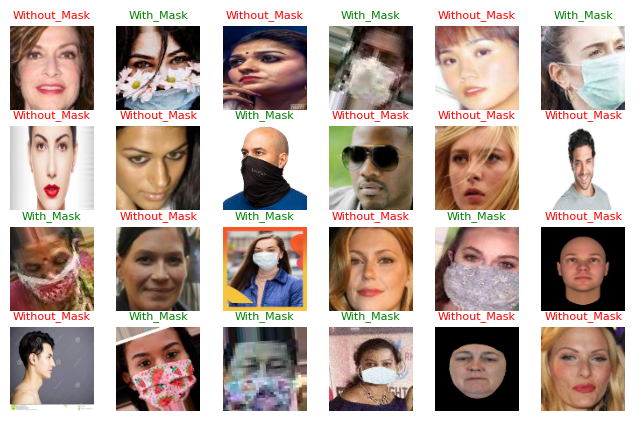

In [9]:
plt.figure(figsize=(8, 5))
for images, labels in train_ds.take(1):
  for i in range(24):
    ax = plt.subplot(4, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]], color = 'g' if labels[i] == 0 else 'r', fontsize=8)
    plt.axis("off")

### Configure the dataset for performance

In the following code cell we are going to configure our dataset for perfomance using `cache` and `prefetch`.


> https://www.tensorflow.org/tutorials/images/classification

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### VGG16 Model

We will download and load the **VGG16** model from `keras.applications` as shown below, which will be used for transfer learning in our face mask detection task.


In [11]:
vgg = keras.applications.VGG16(input_shape=(96, 96, 3), weights='imagenet', include_top=False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

The **VGG16** model comes with approximately **14 million trainable parameters**.  
For our task, we will **freeze all the layers** of the VGG16 model by setting `trainable = False` for each layer, so that the pre-trained weights are not updated during training.


In [12]:
for layer in vgg.layers:
  layer.trainable = False

In [13]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Fine-Tuning `VGG16`

We need to add a **classification head** to our VGG16 model. The steps are as follows:

1. **Flatten** the output of the convolutional base.  
2. Add an additional **Dense layer** for learning complex features.  
3. Add a **Batch Normalization** layer before the output layer to improve training stability.  
4. Add the **final classification layer** suitable for **2 classes** (`With_Mask` and `Without_Mask`).  

We will use the **`Sequential` API** from Keras to construct our model as described above.


> Note that the first layer that we are adding is the `Rescaling` layer that will scale the pixels to be in range `-1` and `1`.

In [14]:
model = keras.Sequential(name="mask_detection")
for index, layer in enumerate(vgg.layers):
    # if index == 1:
    #   model.add(keras.layers.Rescaling(1./255))
    model.add(layer)

model.add(keras.layers.Flatten(name="flatten_layer"))
model.add(keras.layers.Dense(512, activation="relu", name="fc_0"))
model.add(keras.layers.BatchNormalization(name="bn_layer"))
model.add(keras.layers.Dense(2, activation="softmax", name="output_layer"))

model.summary()

Model: "mask_detection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_0 (Dense)                    │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_layer (BatchNormalization)   │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,077,570 (65.15 MB)

 Trainable params: 2,361,858 (9.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

After adding the classification head, our model now has approximately **2 million trainable parameters**.  
We can now **compile** the model with the following settings:

- **Loss function:** `CategoricalCrossentropy` with `from_logits=False`, since the output layer includes a **softmax** activation.  
- **Metrics:** `accuracy` to monitor the model's performance.  
- **Optimizer:** `Adam` with default parameters for efficient gradient-based optimization.


In [15]:
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer = 'adam',
    metrics=["acc"]
)

### Callbacks

We will use **two callbacks** during training to improve performance and prevent overfitting:

1. **ReduceLROnPlateau** - reduces the learning rate when a metric has stopped improving.  
2. **EarlyStopping** - stops training early if the model's performance on the validation set does not improve for a specified number of epochs.


In [16]:
lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, mode='auto'
)

We are now ready to **train the model**.  
Before starting, we will define the **hyperparameters** that will be used during training, such as the number of epochs, batch size, and learning rate.


In [17]:
VERBOSE = 1
BATCH_SIZE = batch_size
VALIDATION_BATCH_SIZE = batch_size
VALIDATION_SPLIT = 0.2
EPOCHS = 10
CALL_BACKS = [lr_reduction, early_stopping]

In [18]:
history = model.fit(
    train_ds,
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = VERBOSE,
    epochs =EPOCHS,
    shuffle = True,
    callbacks=CALL_BACKS
)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1326s 4s/step - acc: 0.9375 - loss: 0.2258 - val_acc: 0.9850 - val_loss: 0.0472 - learning_rate: 0.0010
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - acc: 0.9949 - loss: 0.0169 - val_acc: 0.9850 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - acc: 0.9994 - loss: 0.0048 - val_acc: 0.9882 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - acc: 0.9994 - loss: 0.0032 - val_acc: 0.9880 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - acc: 1.0000 - loss: 3.9262e-04 - val_acc: 0.9877 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - acc: 1.0000 - loss: 2.4855e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - acc: 1.0000 - loss: 2.4840e-04 - val_acc: 0.9870 - val_loss: 0.

### Visualizing the Model Training History

We will visualize the **loss** and **accuracy** metrics stored in the `history` object to analyze the model's performance during training.


In [25]:
df = pd.DataFrame(history.history)
epochs = np.arange(1, len(df["acc"]) + 1)

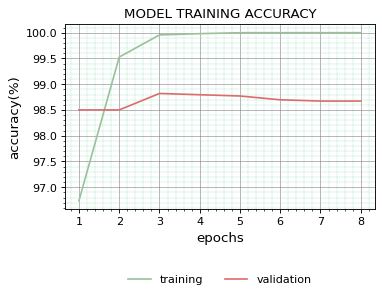

In [27]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs,[i* 100 for i in df["acc"]], label="training", color=PALETTES.christmas[0])
plt.plot(epochs,[i* 100 for i in df["val_acc"]], label="validation", color=PALETTES.christmas[10])
plt.title("MODEL TRAINING ACCURACY", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()


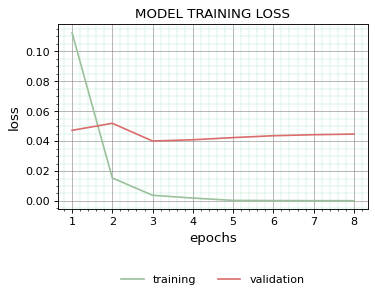

In [28]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, df["loss"], label="training", color=PALETTES.christmas[0])
plt.plot(epochs, df["val_loss"], label="validation", color=PALETTES.christmas[10])
plt.title("MODEL TRAINING LOSS", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()


### Evaluating the Model

In the next code cell, we will **evaluate the model** in terms of **loss** and **accuracy** on the test dataset to measure its performance on the testing dataset.


In [30]:
model.evaluate(test_ds, verbose=1, batch_size=BATCH_SIZE)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - acc: 0.9889 - loss: 0.0377


[0.04470761865377426, 0.9867289066314697]

In the next code cell, we will use the model to **make predictions** on the entire test dataset.  
We will then further evaluate the model using metrics such as the **classification report** and **confusion matrix**.


In [39]:
y_true = []
y_preds = []

for imgs, lbls in test_ds:
  y_true.extend(list(lbls.numpy()))
  preds = np.argmax(model.predict(imgs, verbose=0), axis=1)
  y_preds.extend(list(preds))

y_true = np.array(y_true)
y_preds = np.array(y_preds)
assert len(y_true) == len(y_preds), "y_true and y_preds must be of the same length"


### 🧮 Confusion Matrix

In the next code cell, we will **plot the confusion matrix** for our model.  

This visualization helps us understand how well the model predicts each class and highlights where misclassifications occur.


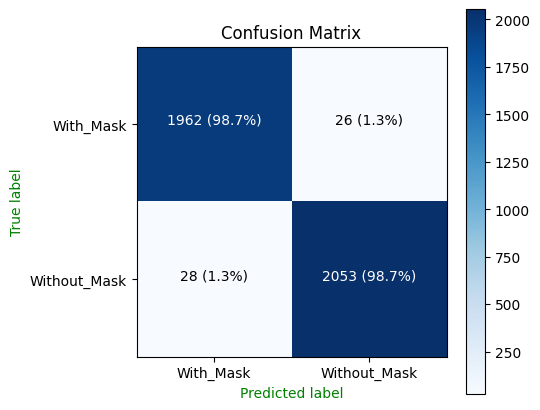

In [40]:
plt.style.use('default')
plot_complicated_confusion_matrix(y_true, y_preds,
  class_names, fontsize=10, figsize=(5, 5), title="Confusion Matrix"
)

### 📋 Classification Report

Next, we will generate and display the **classification report** for our model using the test dataset.  

This report provides key metrics for each class, including **precision**, **recall**, **F1-score**, and **support**.


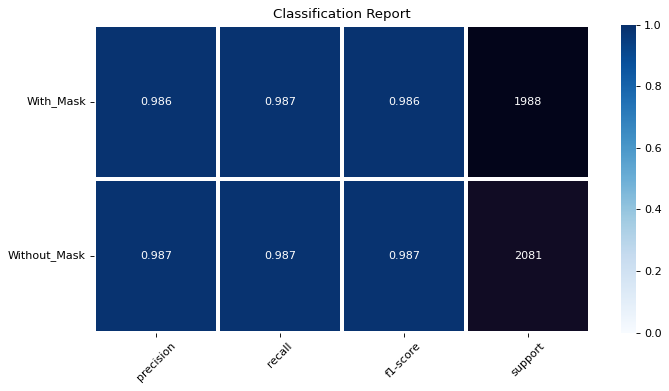

In [41]:
fig, ax = plot_classification_report(
    y_true, y_preds,
    title='Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = class_names
)

### Saving the Model

For a detailed guide on saving models in TensorFlow, you can refer to the [official documentation](https://www.tensorflow.org/guide/keras/save_and_serialize).  

In this notebook, we will save the model using the **H5 format** as shown below.



In [48]:
MODEL_NAME = 'face_mask_detection.keras'
model.save(MODEL_NAME)
print("saved!")

saved!


### Loading the model

For that we are going to use the `keras.models.load_model` function>

In [49]:
loaded_model = keras.models.load_model(MODEL_NAME)

### ``make_prediction`` function

We are going to create a function called `make_prediction` that will make predictions given an image and returns us a good looking response.


In [53]:
def make_prediction(model, image):
  preds = model(np.array([image]))
  predictions = tf.squeeze(preds).numpy()
  prediction = np.argmax(predictions).astype("int32")
  preds_list = [{
      "label": i,
      "class": class_names[i],
      "probability": float(np.round(pred, 2))
  } for i, pred in enumerate(predictions)]
  return {
      "label": int(prediction),
      "class": class_names[prediction],
      "probability": float(np.round(predictions[prediction], 2)),
      "predictions":preds_list
  }

make_prediction(loaded_model, imgs[0])

{'label': 0,
 'class': 'With_Mask',
 'probability': 1.0,
 'predictions': [{'label': 0, 'class': 'With_Mask', 'probability': 1.0},
  {'label': 1, 'class': 'Without_Mask', 'probability': 0.0}]}